In [1]:
import os
import joblib

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error


import shap
import optuna
import category_encoders as ce
import optuna.visualization as vis

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_train = pd.read_csv('../data/train_set.csv')
raw_test = pd.read_csv('../data/test_set.csv')
ss = pd.read_csv('../data/sample_submission.csv')

In [3]:
print(raw_train.info())
raw_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287836 entries, 0 to 287835
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Year                287836 non-null  int64  
 1   OGC                 287836 non-null  int64  
 2   OG                  287836 non-null  object 
 3   DC                  287836 non-null  object 
 4   Dept                287836 non-null  object 
 5   UC                  287836 non-null  int64  
 6   Union               287800 non-null  object 
 7   JF                  287798 non-null  object 
 8   Job                 287836 non-null  object 
 9   EI                  287836 non-null  int64  
 10  Salaries            287836 non-null  int64  
 11  Overtime            287836 non-null  int64  
 12  H/D                 287836 non-null  float64
 13  YT                  287836 non-null  object 
 14  Total_Compensation  287836 non-null  int64  
dtypes: float64(1), int64(7), object(7)

,Year,OGC,OG,DC,Dept,UC,Union,JF,Job,EI,Salaries,Overtime,H/D,YT,Total_Compensation
0,2015,4,Community Health,DPH,Public Health,250,"SEIU - Health Workers, Local 1021",Med Therapy & Auxiliary,Morgue Attendant,6725,12196,0,0.00,Calendar,16158
1,2013,4,Community Health,DPH,Public Health,39,"Stationary Engineers, Local 39",Journeyman Trade,Stationary Engineer,25058,74639,2820,12703.31,Fiscal,115784
2,2015,6,General Administration & Finance,ASR,Assessor/Recorder,21,"Prof & Tech Engineers - Miscellaneous, Local 21",Appraisal & Taxation,Senior Real Property Appraiser,46108,100554,0,12424.50,Calendar,144708
3,2016,1,Public Protection,POL,Police,911,Police Officers' Association,Police Services,Sergeant 3,33369,140164,52754,13043.87,Fiscal,242323
4,2013,2,"Public Works, Transportation & Commerce",HHP,PUC Hetch Hetchy,21,"Prof & Tech Engineers - Miscellaneous, Local 21",Information Systems,IS Engineer-Journey,28684,58813,0,7655.28,Calendar,82106


In [4]:
print(raw_test.info())
raw_test.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47860 entries, 0 to 47859
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      47860 non-null  int64  
 1   OGC       47860 non-null  int64  
 2   OG        47860 non-null  object 
 3   DC        47860 non-null  object 
 4   Dept      47860 non-null  object 
 5   UC        47860 non-null  int64  
 6   Union     47853 non-null  object 
 7   JF        47853 non-null  object 
 8   Job       47860 non-null  object 
 9   EI        47860 non-null  int64  
 10  Salaries  47860 non-null  int64  
 11  Overtime  47860 non-null  int64  
 12  H/D       47860 non-null  float64
 13  YT        47860 non-null  object 
dtypes: float64(1), int64(6), object(7)
memory usage: 5.1+ MB
None


,Year,OGC,OG,DC,Dept,UC,Union,JF,Job,EI,Salaries,Overtime,H/D,YT
0,2016,2,"Public Works, Transportation & Commerce",AIR,Airport Commission,790,"SEIU - Miscellaneous, Local 1021","Budget, Admn & Stats Analysis",Management Assistant,6161,74526,0,13068.800000,Fiscal
1,2013,3,Human Welfare & Neighborhood Development,DSS,Human Services,1,Miscellaneous Unrepresented Employees,Public Service Aide,Public Svc Aide-Public Works,17890,7219,0,3328.053046,Calendar
2,2016,2,"Public Works, Transportation & Commerce",PUC,PUC Public Utilities Commission,21,"Prof & Tech Engineers - Miscellaneous, Local 21",Sub-Professional Engineering,"Stdntdsgntrain1, Arch/Eng/Plng",15092,4616,0,1147.260000,Fiscal


In [13]:
df = raw_train.append(raw_test).reset_index(drop=True)
df.shape

(335696, 15)

In [14]:
ignore = ['OGC', 'DC', 'EI']
df = df.drop(ignore, axis=1)

In [17]:
mask = df['JF'].isna()
print(df.loc[mask]['OG'].value_counts())
print('=' * 50)
print(df.loc[mask]['Dept'].value_counts())
df.loc[mask]

Series([], Name: OG, dtype: int64)
Series([], Name: Dept, dtype: int64)


,Year,OG,Dept,UC,Union,JF,Job,Salaries,Overtime,H/D,YT,Total_Compensation


In [16]:
missing_dict = df.groupby('Dept')['JF', 'Union'].agg(pd.Series.mode).T.to_dict()

mask = (df['JF'].isna()) | (df['Union'].isna())
missing_idx = df.loc[mask].index

for i in missing_idx:
    key = df.iloc[i]['Dept']
    df.loc[:, 'JF'][i] = missing_dict[key]['JF']
    if df.iloc[i]['Union'] != 'Municipal Exec Assoc-Misc':
        df.loc[:, 'Union'][i] = missing_dict[key]['Union']

In [20]:
cat_cols = ['Year', 'OG', 'Dept', 'Union', 'JF', 'Job', 'YT']

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [21]:
print(df.info())
print('=================== Missing values ==================')
print(df.isna().sum())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335696 entries, 0 to 335695
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Year                335696 non-null  int64  
 1   OG                  335696 non-null  int64  
 2   Dept                335696 non-null  int64  
 3   UC                  335696 non-null  int64  
 4   Union               335696 non-null  int64  
 5   JF                  335696 non-null  int64  
 6   Job                 335696 non-null  int64  
 7   Salaries            335696 non-null  int64  
 8   Overtime            335696 non-null  int64  
 9   H/D                 335696 non-null  float64
 10  YT                  335696 non-null  int64  
 11  Total_Compensation  287836 non-null  float64
dtypes: float64(2), int64(10)
memory usage: 30.7 MB
None
=================== Missing values ==================
Year                      0
OG                        0
Dept                  

,Year,OG,Dept,UC,Union,JF,Job,Salaries,Overtime,H/D,YT,Total_Compensation
0,2,0,45,250,57,28,673,12196,0,0.00,0,16158.0
1,0,0,45,39,63,23,1014,74639,2820,12703.31,1,115784.0
2,2,2,5,21,52,6,913,100554,0,12424.50,0,144708.0
3,3,5,42,911,47,35,927,140164,52754,13043.87,1,242323.0
4,0,6,38,21,52,22,498,58813,0,7655.28,0,82106.0


In [22]:
target_col = 'Total_Compensation'
mask = df[target_col].isna() == True

train = df.loc[~mask]
train[target_col] = train[target_col].astype(int)

test = df.loc[mask].drop(target_col, axis=1)

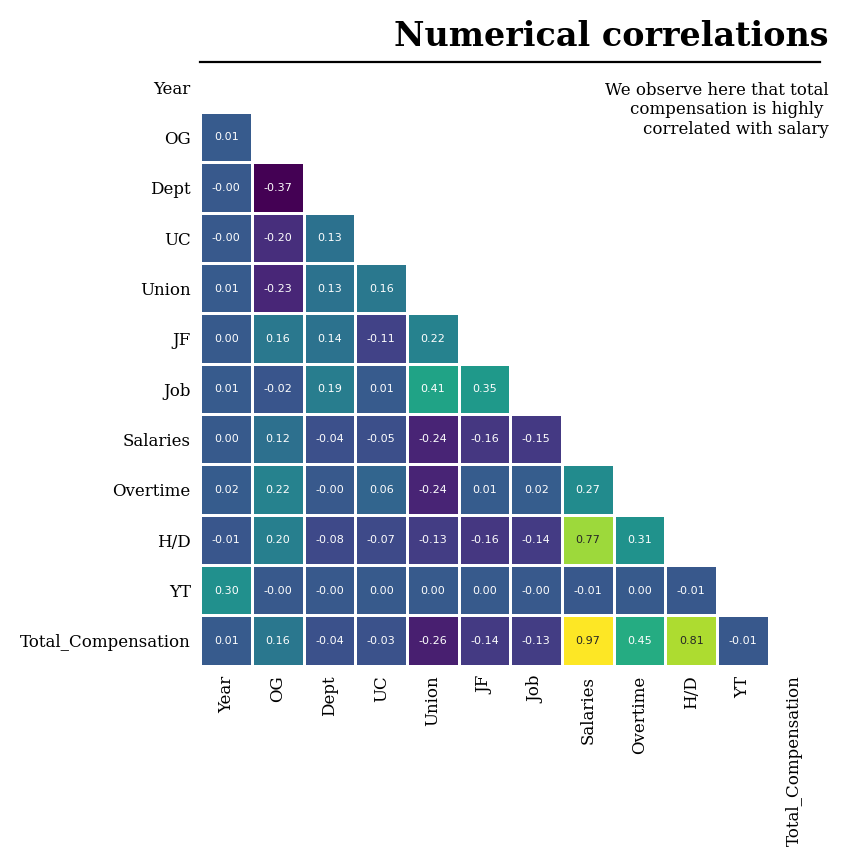

In [29]:
corr = train.corr()

# Setting up figure and axes
fig = plt.figure(figsize=(4, 4), dpi=200) # create figure
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0.8)
ax0 = fig.add_subplot(gs[0, 0]) # create axis

mask = np.triu(corr)
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(corr, mask=mask, annot=True, cbar=False, fmt='.2f',
            linewidths=0.5, cmap='viridis', ax=ax0, annot_kws={'fontsize': 4})

ax0.set_yticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation = 0, fontsize=6)
ax0.set_xticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation=90, fontsize=6)

ax0.spines['top'].set_visible(True)
ax0.tick_params(axis='both', which='both', length=0)

fig.text(0.91, 0.90, 'Numerical correlations', fontweight='bold', 
         fontfamily='serif', fontsize=12, ha='right')
fig.text(0.91, 0.88, '''
We observe here that total
compensation is highly 
correlated with salary
''', 
         fontweight='light', fontfamily='serif', fontsize=6, va='top', ha='right')

plt.tight_layout()
plt.show()

In [30]:
train.to_csv('../data/simple_train1.csv', index=False)
test.to_csv('../data/simple_test1.csv', index=False)